In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from helpers import combine_position_data
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import root_mean_squared_error, r2_score

In [2]:
data_directory = "Fantasy-Premier-League/data"
seasons = ["2022-23", "2023-24", "2024-25"]
positions = ["DEF", "MID", "FWD"]
output_file_name = "xga_training_data.csv"

combine_position_data(data_directory, seasons, positions, output_file_name)

Loaded data from DEF_players.csv for season 2022-23.
Loaded data from MID_players.csv for season 2022-23.
Loaded data from FWD_players.csv for season 2022-23.
Loaded data from DEF_players.csv for season 2023-24.
Loaded data from MID_players.csv for season 2023-24.
Loaded data from FWD_players.csv for season 2023-24.
Loaded data from DEF_players.csv for season 2024-25.
Loaded data from MID_players.csv for season 2024-25.
Loaded data from FWD_players.csv for season 2024-25.
Combined data saved to Fantasy-Premier-League/data/training_data/xga_training_data.csv.


In [3]:
data_directory = "Fantasy-Premier-League/data/training_data"
training_file = os.path.join(data_directory, "xga_training_data.csv")
data = pd.read_csv(training_file)

# Here we predict xG so we can skip the players who didn't play at all
data = data[data['minutes'] > 60]

# Feature engineering
data['was_home'] = data['was_home'].astype(int)
data['home_crowd_effect'] = data['was_home'] * data['crowds']
data = data.sort_values(by=["unique_id", "season", "gameweek"])

data['rolling_xg_5'] = (
    data.groupby('unique_id')['expected_goals']
    .shift(1)  # Shift by 1 to exclude the current row
    .rolling(window=5, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)  # Remove the grouping index
)

data['rolling_xg_5'].fillna(0)

# One-hot encoding for categorical features
data = pd.get_dummies(data, columns=["POS", "season"], drop_first=True)

numerical_features = [
    "gameweek", "value", "home_crowd_effect", 
    "opponent_defense", "own_attack", "rolling_xg_5", "unique_id"
]
categorical_features = [col for col in data.columns if col.startswith("POS_") or col.startswith("season_")]
features = numerical_features + categorical_features
target = "expected_goals"

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse}")

cv_scores = cross_val_score(
    model,
    X_train,
    y_train,
    cv=5,
    scoring="neg_root_mean_squared_error"
)
cv_rmse = -np.mean(cv_scores)
print(f"Cross-validated RMSE: {cv_rmse}")

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

models_folder = "models"
os.makedirs(models_folder, exist_ok=True)
model_path = os.path.join(models_folder, "xgboost_xg_prediction_model.json")
model.save_model(model_path)
print(f"Model saved at: {model_path}")

/tmp/ipykernel_41151/856349651.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['rolling_xg_5'].fillna(0, inplace=True)


RMSE: 0.218203927619252
Cross-validated RMSE: 0.21651072163054338
R-squared: 0.2615135529816516
Model saved at: models/xgboost_xg_prediction_model.json


<Figure size 1000x800 with 0 Axes>

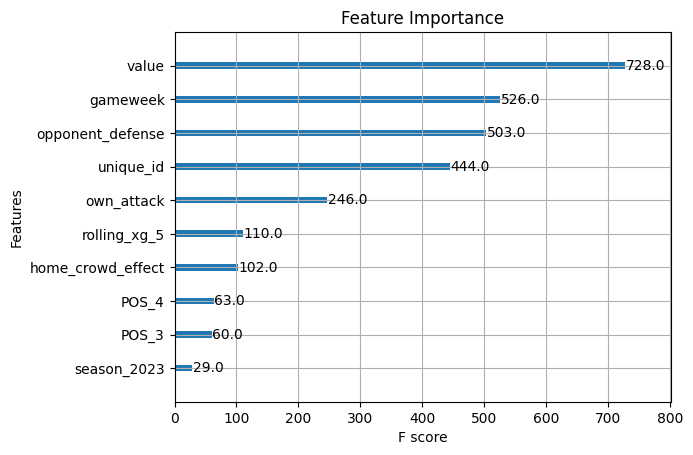

In [4]:
plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=10, importance_type="weight")
plt.title("Feature Importance")
plt.show()

In [5]:
# Now similar for predicting assists
data_directory = "Fantasy-Premier-League/data/training_data"
training_file = os.path.join(data_directory, "xga_training_data.csv")
data = pd.read_csv(training_file)

# Here we predict xG so we can skip the players who didn't play at all
data = data[data['minutes'] > 60]

# Feature engineering
data['was_home'] = data['was_home'].astype(int)
data['home_crowd_effect'] = data['was_home'] * data['crowds']
data = data.sort_values(by=["unique_id", "season", "gameweek"])

data['rolling_xa_5'] = (
    data.groupby('unique_id')['expected_assists']
    .shift(1)
    .rolling(window=5, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

data['rolling_xa_5'].fillna(0)


# One-hot encoding for categorical features
data = pd.get_dummies(data, columns=["POS", "season"], drop_first=True)

numerical_features = [
    "gameweek", "value", "home_crowd_effect", 
    "opponent_defense", "own_attack", "rolling_xa_5", "unique_id"
]
categorical_features = [col for col in data.columns if col.startswith("POS_") or col.startswith("season_")]
features = numerical_features + categorical_features
target = "expected_assists"

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse}")

cv_scores = cross_val_score(
    model,
    X_train,
    y_train,
    cv=5,
    scoring="neg_root_mean_squared_error"
)
cv_rmse = -np.mean(cv_scores)
print(f"Cross-validated RMSE: {cv_rmse}")

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

models_folder = "models"
os.makedirs(models_folder, exist_ok=True)
model_path = os.path.join(models_folder, "xgboost_xa_prediction_model.json")
model.save_model(model_path)
print(f"Model saved at: {model_path}")

/tmp/ipykernel_41151/3500524482.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['rolling_xa_5'].fillna(0, inplace=True)


RMSE: 0.12969140912372573
Cross-validated RMSE: 0.1246759924553978
R-squared: 0.18310729457920927
Model saved at: models/xgboost_xa_prediction_model.json


<Figure size 1000x800 with 0 Axes>

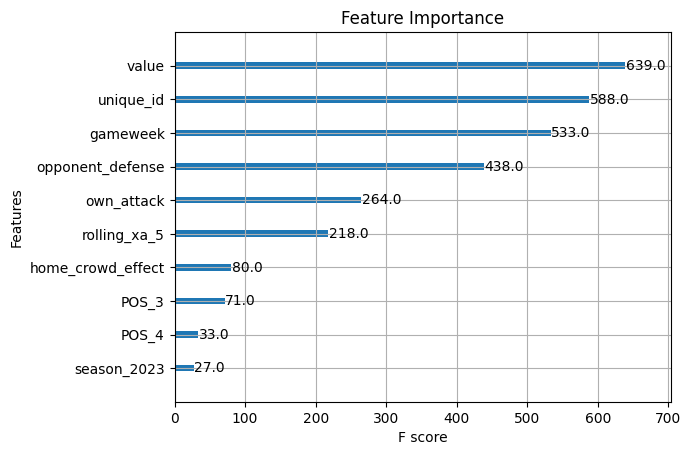

In [6]:
plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=10, importance_type="weight")
plt.title("Feature Importance")
plt.show()